<p align="left">
  <a href="https://colab.research.google.com/github/fernandoarcevega/AI_Workshop/blob/main/Day_2/02_MLP/02_MLP_mnl.ipynb" target="_parent">
    <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab" width="200">
  </a>
</p>

In [ ]:
###############################################
# Author 1: Wilfrido Gómez-Flores (CINVESTAV) #
# Author 2: Fernando Arce-Vega (CIO)          #
# e-mail 1: wilfrido.gomez@cinvestav.mx       #
# e-mail 2: farce@cio.mx                      #
# Date:     nov/03/2025                       #
# Subject:  Multi-layer perceptron            #
###############################################

In [ ]:
# Libraries
import numpy as np                       # Numerical array operations
import pandas as pd                      # Data manipulation/analysis
import matplotlib.pyplot as plt          # Data plotting/visualization

In [ ]:
# Load dataset
# Path to dataset
path = 'https://raw.githubusercontent.com/fernandoarcevega/AI_Workshop/main/datasets/spirals3.csv'
T = pd.read_csv(path)
data = T.values
n, d = data.shape
X = data[:, :d-1]      # Features
Y = data[:, d-1]       # Class labels

In [ ]:
# Check feature and targets shapes
print(f'Features shape: {X.shape}')
print(f'Targets shape:  {Y.shape}')

Features shape: (1350, 2)
Targets shape:  (1350,)


Text(0.5, 1.0, 'XOR problem')

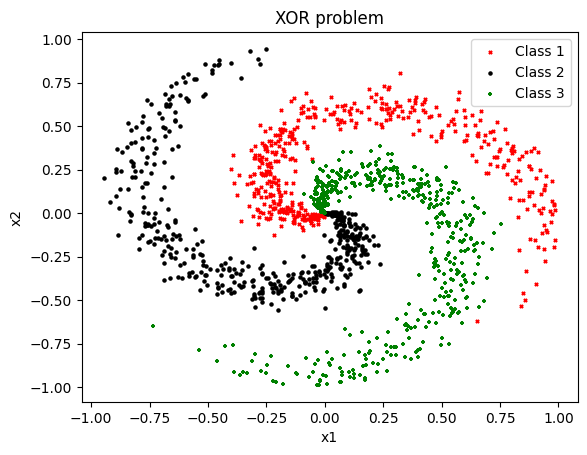

In [ ]:
# Plotting training data
plt.scatter(X[Y == 1, 0], X[Y == 1, 1], color='red', s=5, marker='x', label='Class 1')
plt.scatter(X[Y == 2, 0], X[Y == 2, 1], color='black', s=5, marker='o', label='Class 2')
plt.scatter(X[Y == 3, 0], X[Y == 3, 1], color='green', s=5, marker='+', label='Class 3')
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.title('XOR problem')

Training **MLP** with **backpropagation**:

$$
\begin{align*}
& \textbf{input:} \quad X = \{(\mathbf{x}_i, \mathbf{t}_i) | i = 1, \dots, n\}, \eta > 0, \varepsilon > 0, r_{\max} \\
\\
1: \quad & \text{Initialize network weights: } w_{ji} \leftarrow \text{rand}, w_{kj} \leftarrow \text{rand} \\
2: \quad & \textbf{for } r = 1, 2, \dots, r_{\max} \textbf{ do} \\
3: \quad & \qquad \Delta w_{ji} \leftarrow 0, \Delta w_{kj} \leftarrow 0 \\
4: \quad & \qquad \textbf{for } l = 1, 2, \dots, n \textbf{ do} \\
5: \quad & \qquad \qquad z_k = \text{MLP}(\mathbf{x}_l) && \triangleright \text{Feedforward} \\
6: \quad & \qquad \qquad \Delta w_{ji} \leftarrow \Delta w_{ji} + \eta \delta_j x_{li} && \triangleright \text{Delta rules} \\
7: \quad & \qquad \qquad \Delta w_{kj} \leftarrow \Delta w_{kj} + \eta \delta_k y_j \\
8: \quad & \qquad w_{ji} \leftarrow w_{ji} - \Delta w_{ji} && \triangleright \text{Weights update} \\
9: \quad & \qquad w_{kj} \leftarrow w_{kj} - \Delta w_{kj} \\
\\
& \textbf{return:} \quad w_{ji}, w_{kj}
\end{align*}
$$

In [ ]:
# MLP training
def mlp_train(X, Y, h, eta, l, epochMax):
    c = int(max(Y))
    n, d = X.shape
    tk = (Y[:, None] == np.arange(1, c + 1)).astype(float)  # One-hot encoding
    ones = np.ones((n, 1))
    X = np.hstack((ones, X))                                # Add dummy inputs for biases calculation

    # Functions
    sg = lambda x: 1 / (1 + np.exp(-x))                                     # Sigmoid activation function
    sm = lambda x: np.exp(x) / np.sum(np.exp(x), axis=1, keepdims=True)     # Softmax function
    ce = lambda t, z: -np.sum(t * np.log(z + np.finfo(float).eps), axis=1)  # Cross-entropy loss function

    # Weights initialization
    rd = lambda a, b, s, t: a + (b - a) * np.random.rand(s, t)  # LeCun initialization
    Wji = rd(-np.sqrt(3/d), np.sqrt(3/d), h, d + 1)             # Input-hidden layer weights
    Wkj = rd(-np.sqrt(3/h), np.sqrt(3/h), c, h + 1)             # Hidden-output layer weights

    # Training loop
    Jn = np.zeros(epochMax)  # Save loss function
    for t in range(epochMax):

        # Shuffle data every epoch
        id = np.random.permutation(n)
        X = X[id, :]
        tk = tk[id, :]

        # Feedforward
        yj = sg(X @ Wji.T)                          # Hidden layer response
        yj = np.hstack((ones, yj))                  # Add dummy inputs
        zk = sm(yj @ Wkj.T)                         # Output layer response
        L2 = l * (np.sum(Wji**2) + np.sum(Wkj**2))  # Regularization term
        Jn[t] = np.mean(ce(tk, zk)) + L2            # Cross-entropy loss (regularized)

        # Backpropagation
        dk = zk - tk                      # Delta k
        Dwkj = dk.T @ yj                  # Delta rule hidden-output
        dj = (dk @ Wkj) * (yj * (1 - yj)) # Delta j
        Dwji = dj[:, 1:h + 1].T @ X       # Delta rule input-hidden

        # Weights update (regularized)
        Wji = (1 - eta * l) * Wji - eta * Dwji  # Input-hidden
        Wkj = (1 - eta * l) * Wkj - eta * Dwkj  # Hidden-output

    return Wji, Wkj, Jn

In [ ]:
# MLP prediction
def mlp_predict(X, Wji, Wkj):
    sg = lambda x: 1 / (1 + np.exp(-x))                                 # Sigmoid activation function
    sm = lambda x: np.exp(x) / np.sum(np.exp(x), axis=1, keepdims=True) # Softmax function
    unos = np.ones((X.shape[0], 1))                                     # Ones vector
    X = np.hstack((unos, X))                                            # Add dummy inputs
    yj = sg(X @ Wji.T)                                                  # Hidden layer response
    yj = np.hstack((unos, yj))                                          # Add dummy inputs
    zk = sm(yj @ Wkj.T)                                                 # Output layer response
    ypp = np.argmax(zk, axis=1) + 1                                     # Classification by maximum probability
    return ypp, zk

In [ ]:
# Hyper-parameters
h = 15               # Hidden neurons
epochMax = 5000     # Number of training epochs
eta = 1e-3          # Learning rate
lam = 1e-8          # Regularization factor

In [ ]:
# Train MLP
Wji, Wkj, Jn = mlp_train(X, Y, h, eta, lam, epochMax)  # Train MLP

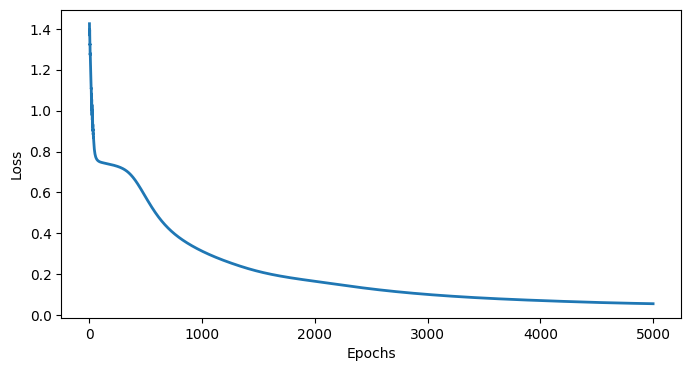

In [ ]:
# Training performance
pt = 500
X1, X2 = np.meshgrid(np.linspace(-1, +1, pt), np.linspace(-1, +1, pt))
Ypp, zk = mlp_predict(np.c_[X1.ravel(), X2.ravel()], Wji, Wkj)    # Predict feature space
Ypp = Ypp.reshape(pt, pt)

plt.figure(figsize=(8, 4))
plt.plot(np.arange(1, len(Jn) + 1), Jn, linewidth=2)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

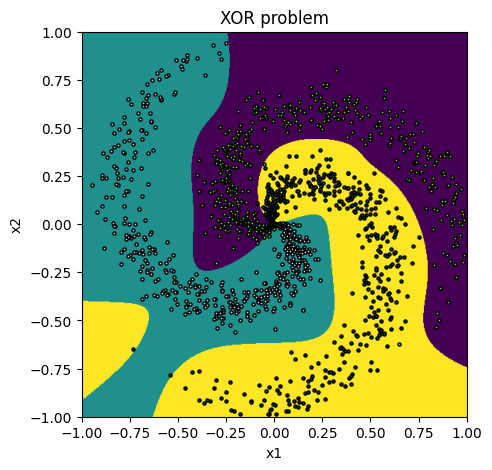

In [ ]:
# MLP
plt.figure(figsize=(5, 5))
plt.imshow(Ypp, extent=(X1.min(), X1.max(), X2.min(), X2.max()), origin='lower')

for i in range(1, int(max(Y)) + 1):
    plt.scatter(X[Y == i, 0], X[Y == i, 1], color=np.random.rand(3,), s=5, edgecolor='k')

#plt.scatter(X[Y == 1, 0], X[Y == 1, 1], color='red', s=5, marker='x', label='Class 1')
#plt.scatter(X[Y == 2, 0], X[Y == 2, 1], color='black', s=5, marker='o', label='Class 2')

plt.xlabel('x1')
plt.ylabel('x2')
plt.title('XOR problem')
plt.show()